# Use critical embedding of the lab microbiome to forecast target dynamics

Author: Zhengqing Zhou
Updated: 2025/06/13

In this notebook, we use the critical embedding to forecast the ASV's future dynamics.

In [1]:
import numpy as np
import torch
from torch.nn import functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import sys

import time as timer
import pickle

from tqdm.notebook import trange
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Configure GPU if available
if torch.cuda.is_available():

    device = "cuda:0"
else:
    device = "cpu"

# VAE Network
The VAE network has 16 channels in the encoder, consisting of 3 convolutional layers, each followed by a leaky relu function, with kernel = 3, strid = 1, and padding = 1, so the time series (length of 30) will not get shortened during the convolutions; and two parallel linear layers to project the encoded time series to the mean value and var of the latent dimension, based on which a gaussian sampling will be done, generating the embedding of the data. The embedding is further decoded by a decoder of the symmetrical structure.

In [2]:
class VAE(nn.Module):

    def __init__(self, n_target, latent_dim):
        # Call parent model constructor and store hidden state variables.
        super().__init__()
        self.latent_dim = latent_dim
        self.n_target = n_target
        self.channels = 16

        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=self.n_target, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
        )

        self.mean_map = nn.Linear(self.channels * 30, self.latent_dim)

        self.std_map = nn.Linear(self.channels * 30, self.latent_dim)

        self.fc_decoder = nn.Sequential(
            nn.Linear(self.latent_dim, self.channels * 30),
            nn.LeakyReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.channels, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU(),
            nn.ConvTranspose1d(in_channels=self.channels, out_channels=self.n_target, kernel_size=3, stride=1,
                               padding=1),
            nn.LeakyReLU()
        )

    def sample(self, mean, log_var):
        """Sample a given N(0,1) normal distribution given a mean and log of variance."""

        # First compute the variance from the log variance.
        var = torch.exp(0.5 * log_var)

        # Compute a scaled distribution
        eps = torch.randn_like(var)

        # Add the vectors
        z = mean + var * eps

        return z

    def forward(self, X):
        """Forward propogate through the model, return both the reconstruction and sampled mean and standard deviation
        for the system.
        """
        pre_code = self.encoder(X)
        B, C, L = pre_code.shape
        flattened = pre_code.view(B, C * L)

        mu = self.mean_map(flattened)
        log_var = self.std_map(flattened)

        code = self.sample(mu, log_var)

        # Pass through FC layers before decoding
        post_code = self.fc_decoder(code)

        X_hat = self.decoder(post_code.view(B, C, L))

        return X_hat, code, mu, log_var


def vae_loss(x_hat, x, mu, log_var):
    "Compute the sum of BCE and KL loss for the distribution."

    # weight for the KL divergence
    alpha = 1e-4

    # Compute the reconstruction loss
    BCE = F.mse_loss(x_hat, x)

    # Compute the KL divergence of the distribution.
    KLD = -0.5 * torch.mean(1 + log_var - mu.pow(2) - log_var.exp())

    return BCE + alpha * KLD

In [3]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Use the embedding to forecast target ASV dynamics
For this dataset, we ask if the embedding contains information to forecast the abundance of the target ASV and the beta-diversity in community composition at the next time point

In [4]:
class MLP_InLatent(nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

        self.channels = 512

        # 1) Freeze every VAE parameter
        for p in self.vae.parameters():
            p.requires_grad = False
        self.vae.eval()  # optional, puts dropout/bn in eval mode

        latent_dim = vae.latent_dim
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, latent_dim),
        )

    def forward(self, X):
        """
        Args:
            X: (B, n_target, L)
        Returns:
            X_hat:   (B, n_target, L)  ← decoded from z_mapped
            z:       (B, latent_dim)   ← latent of the input
            z_mapped:(B, latent_dim)   ← z after MLP
            mu:      (B, latent_dim)   ← from VAE encoder
            log_var: (B, latent_dim)   ← from VAE encoder
        """
        # 1) run through frozen encoder & sampler
        with torch.no_grad():
            pre_code = self.vae.encoder(X)              # → (B, C, L)
            B, C, L = pre_code.shape
            flat   = pre_code.view(B, C * L)            # → (B, C*L)
            mu     = self.vae.mean_map(flat)            # → (B, latent_dim)
            log_var= self.vae.std_map(flat)             # → (B, latent_dim)
            z      = self.vae.sample(mu, log_var)       # → (B, latent_dim)

        # 2) map in latent space
        z_mapped = self.mlp(z)                          # → (B, latent_dim)

        # 3) decode via the original VAE’s decoder
        post = self.vae.fc_decoder(z_mapped)            # → (B, C*L)
        X_hat = self.vae.decoder(post.view(B, C, L))    # → (B, n_target, L)

        return X_hat, z_mapped, mu, log_var

In [5]:
def get_forecast_data_all(sample: str, delta_T: int, n_ref: int):
    """
    For a given sample and delta_T, returns:
      Seg1: np.ndarray, shape (8, n_segments, n_asv, 30)
      Seg2: np.ndarray, shape (8, n_segments, n_asv, 30)

    Each [rep, i, :, :] is the i-th segment for replicate rep.
    """
    # load the 8 replicates in one shot: shape (8, timepoints, n_asv)
    data_all = np.load(f"./lab_microbiome_datasets_CV/ranked/{sample}_ranked_relative.npy")
    n_reps = data_all.shape[0]
    timepoints = data_all.shape[1]
    if n_ref == -1:
        n_asv = data_all.shape[2]
    else:
        n_asv = n_ref
    

    T = 30
    # determine number of segments per rep
    n_segments = timepoints - T + 1 - delta_T

    # pre-allocate
    Seg1 = np.zeros((n_reps, n_segments, n_asv, T), dtype=data_all.dtype)
    Seg2 = np.zeros((n_reps, n_segments, n_asv, T), dtype=data_all.dtype)

    for rep in range(n_reps):
        rep_data = data_all[rep]  # shape (timepoints, n_asv)
        for i in range(n_segments):
            window1 = rep_data[i : i + T, 0:n_asv].T            # (n_asv, 30)
            window2 = rep_data[i + delta_T : i + T + delta_T, 0:n_asv].T
            Seg1[rep, i] = window1
            Seg2[rep, i] = window2

    return Seg1, Seg2


In [6]:
#train and test function for mlp
def train_model(model, data_loader, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.mlp.train()

    for x,y in data_loader:
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        pred,_,_,_ = model(x)
        loss = F.mse_loss(pred, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

def test_model(model, data_loader):

    num_batches = len(data_loader)
    total_loss = 0

    model.mlp.eval()
    with torch.no_grad():
        for x,y in data_loader:
            x = x.to(device)
            y = y.to(device)
            pred,_,_,_ = model(x)
            loss = F.mse_loss(pred, y)
            total_loss += loss.item()

    avg_loss = total_loss / num_batches
    return avg_loss

In [7]:
def run_mlp_cv(sample: str, delta_T: int, trial: int):
    EPOCHS = 200
    lr0 = 1e-3
    lr_decay = 0.99
    batch_size = 32

    n_ref = 5

    # 1) load all 8 replicates at once
    Seg1_all, Seg2_all = get_forecast_data_all(sample, delta_T, n_ref)
    # shapes: (8, n_segs, n_asv, T)
    n_reps, n_segs, n_asv, T = Seg1_all.shape

    # 2) load Ec & VAE model
    data_ec = np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")
    Ec = int(np.ceil(data_ec[1, 0]))
    vae_ckpt = f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth"
    vae = VAE(n_target=1, latent_dim=Ec)
    vae.load_state_dict(torch.load(vae_ckpt, weights_only=True))
    vae.to(device).eval()

    train_losses = np.zeros((n_reps, EPOCHS))
    test_losses = np.zeros((n_reps, EPOCHS))

    for test_rep in range(n_reps):

        torch.manual_seed(test_rep+10*trial)
        # --- assemble train‐replicates and flatten per‐ASV ---
        train_reps = [r for r in range(n_reps) if r != test_rep]

        # pick and reshape:
        X_tr = Seg1_all[train_reps]  # (7, n_segs, n_asv, T)
        Y_tr = Seg2_all[train_reps]

        # first flatten reps+segments: → (7*n_segs, n_asv, T)
        X_tr = X_tr.reshape(-1, n_asv, T)
        Y_tr = Y_tr.reshape(-1, n_asv, T)
        # then flatten per-ASV: → (7*n_segs*n_asv, T)
        X_tr = X_tr.reshape(-1, T)
        Y_tr = Y_tr.reshape(-1, T)
        # add channel dim for VAE(n_target=1): → (N, 1, T)
        X_tr = X_tr[:, None, :]
        Y_tr = Y_tr[:, None, :]

        # to torch
        X_tr = torch.from_numpy(X_tr).float()
        Y_tr = torch.from_numpy(Y_tr).float()

        # --- prepare & evaluate on the held‐out replicate ---
        X_te = Seg1_all[test_rep]  # (n_segs, n_asv, T)
        Y_te = Seg2_all[test_rep]
        # flatten exactly as above:
        X_te = X_te.reshape(-1, T)[:, None, :]
        Y_te = Y_te.reshape(-1, T)[:, None, :]
        X_te = torch.from_numpy(X_te).float()
        Y_te = torch.from_numpy(Y_te).float()

        # Create train/test data for this fold
        train_loader = DataLoader(TensorDataset(X_tr, Y_tr), batch_size=batch_size, shuffle=True)
        test_loader = DataLoader(TensorDataset(X_te, Y_te), batch_size=batch_size, shuffle=False)

        # --- MLP for this fold ---
        model = MLP_InLatent(vae).to(device)
        lr = lr0*1
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # --- train on this fold ---
        model.train()
        for epoch in trange(EPOCHS, desc=f"Fold {test_rep+1}", leave=False):
            tr_loss = train_model(model, train_loader, optimizer)
            te_loss = test_model(model, test_loader)
            train_losses[test_rep, epoch] = tr_loss
            test_losses[test_rep, epoch] = te_loss
            lr *= lr_decay
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        torch.save(model.state_dict(),
                   f"./mlp_models/target_forecast/{sample}_universal_fold{test_rep + 1}_{delta_T}day_trial{trial}.pth")

    # --- summary across folds ---
    print("\n8-fold CV summary:")
    print(f"  Train MSE: {np.mean(train_losses):.2e} ± {np.std(train_losses):.2e}")
    print(f"  Test  MSE: {np.mean(test_losses):.2e} ± {np.std(test_losses):.2e}")

    return train_losses, test_losses



In [ ]:
sample = "Water-A"
delta_T = 5
trial = 5
train_mses, test_mses = run_mlp_cv(sample, delta_T, trial)

In [ ]:
fig,axes=plt.subplots(2,4,figsize=(8,4))
axes=axes.flat
for i in range(8):
    ax=axes[i]
    ax.plot(train_mses[i,:],label="train")
    ax.plot(test_mses[i,:],label="test")
    ax.set_ylim([1e-3,1e-1])
    ax.set_yscale("log")
axes[0].legend()
fig.tight_layout()
plt.show()

ASV 1: N=1840, MSE=0.014, var=0.108
ASV 1: N=1840, R²=0.874, ρ=0.942, ρ²=0.887
ASV 2: N=1840, MSE=0.009, var=0.025
ASV 2: N=1840, R²=0.645, ρ=0.803, ρ²=0.645
ASV 3: N=1840, MSE=0.005, var=0.022
ASV 3: N=1840, R²=0.777, ρ=0.883, ρ²=0.781
ASV 4: N=1840, MSE=0.004, var=0.012
ASV 4: N=1840, R²=0.634, ρ=0.825, ρ²=0.680
ASV 5: N=1840, MSE=0.003, var=0.015
ASV 5: N=1840, R²=0.824, ρ=0.908, ρ²=0.825


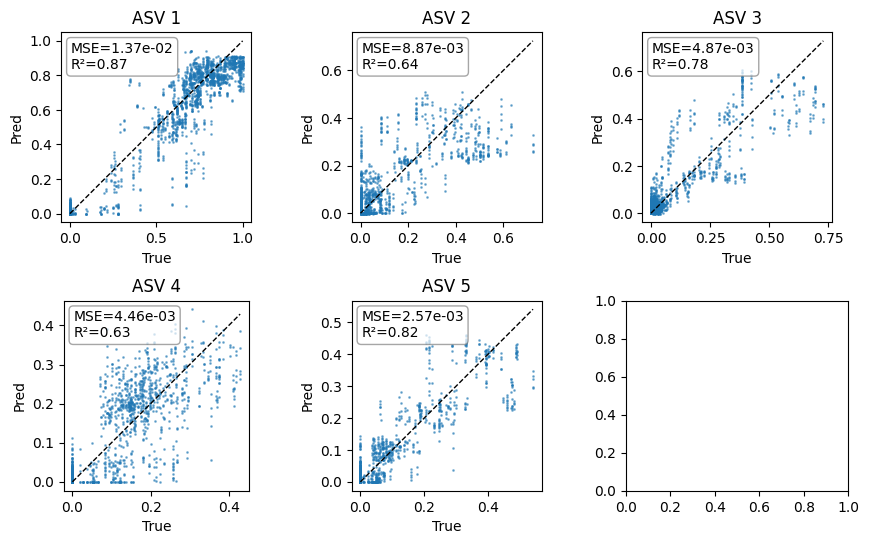

In [23]:
from sklearn.metrics import mean_squared_error, r2_score

sample = "Water-A"
delta_T = 5
trial = 1

model_dir = "./mlp_models/target_forecast"

# 1) load data
Seg1_all, Seg2_all = get_forecast_data_all(sample, delta_T, 5)
n_reps, n_segs, n_asv, T = Seg1_all.shape

# 2) pick top-5 ASVs (here fixed to 0–4)
targets = np.arange(5)

# 3) containers
preds_dict  = {asv: [] for asv in targets}
truths_dict = {asv: [] for asv in targets}

# 4) load Ec
Ec = int(np.ceil(np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")[1,0]))

for test_rep in range(n_reps):
    # load and move VAE+MLP to GPU
    vae = VAE(n_target=1, latent_dim=Ec).to("cuda:0")
    vae_ckpt = f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth"
    vae.load_state_dict(torch.load(vae_ckpt, weights_only=True))
    vae.eval()
    model = MLP_InLatent(vae).to("cuda:0").eval()
    ckpt = f"./mlp_models/target_forecast/{sample}_universal_fold{test_rep + 1}_{delta_T}day_trial{trial}.pth"
    model.load_state_dict(torch.load(ckpt,weights_only=True))

    # Output container: shape (n_segs, n_asv, T)
    preds = np.zeros((n_segs, n_asv, T))
    
    # Loop over ASVs and predict one-by-one
    for asv in range(n_asv):
        # Extract input segment for this ASV only
        X_asv = Seg1_all[test_rep][:, asv, :]  # shape: (n_segs, T)
        X_asv = X_asv[:, None, :]              # add channel → (n_segs, 1, T)
        X_asv_t = torch.from_numpy(X_asv).float().to("cuda:0")
    
        with torch.no_grad():
            X_hat, _, _, _ = model(X_asv_t)     # shape: (n_segs, 1, T)
    
        preds[:, asv, :] = X_hat.squeeze(1).cpu().numpy()
    truth = Seg2_all[test_rep]

    # collect only the last delta_T points
    for asv in targets:
        preds_flat  = preds[:, asv, -delta_T:].reshape(-1)
        truth_flat  = truth[:, asv, -delta_T:].reshape(-1)
        preds_dict[asv] .extend(preds_flat.tolist())
        truths_dict[asv].extend(truth_flat.tolist())

# ── Compute & plot ────────────────────────────────────────────────────────────────
fig, axes = plt.subplots(2,3, figsize=(9, 6))
axes = axes.flatten()

for idx, asv in enumerate(targets):
    ax = axes[idx]
    y_true = np.array(truths_dict[asv])
    y_pred = np.array(preds_dict[asv])
    mse = mean_squared_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    var = np.var(y_true)
    corr = np.corrcoef(y_true, y_pred)[0,1]
    print(f"ASV {asv+1}: N={len(y_true)}, MSE={mse:.3f}, var={var:.3f}")
    print(f"ASV {asv+1}: N={len(y_true)}, R²={r2:.3f}, ρ={corr:.3f}, ρ²={corr**2:.3f}")
    
    ax.scatter(y_true, y_pred, alpha=0.5, s=1)
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            'k--', linewidth=1)  # identity line
    ax.set_title(f"ASV {asv+1}")
    ax.set_xlabel("True")
    ax.set_ylabel("Pred")
    # annotate in upper‐left corner
    ax.text(0.05, 0.95,
            f"MSE={mse:.2e}\nR²={r2:.2f}",
            transform=ax.transAxes,
            va='top',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7)
           )
    ax.set_aspect('equal')

#fig.suptitle(f"{sample}: Top-5 ASV forecasts (δT={delta_T})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Visualize the prediction of all five communities
**analyses below this point requires downloading the entire dataset from Zenodo.**

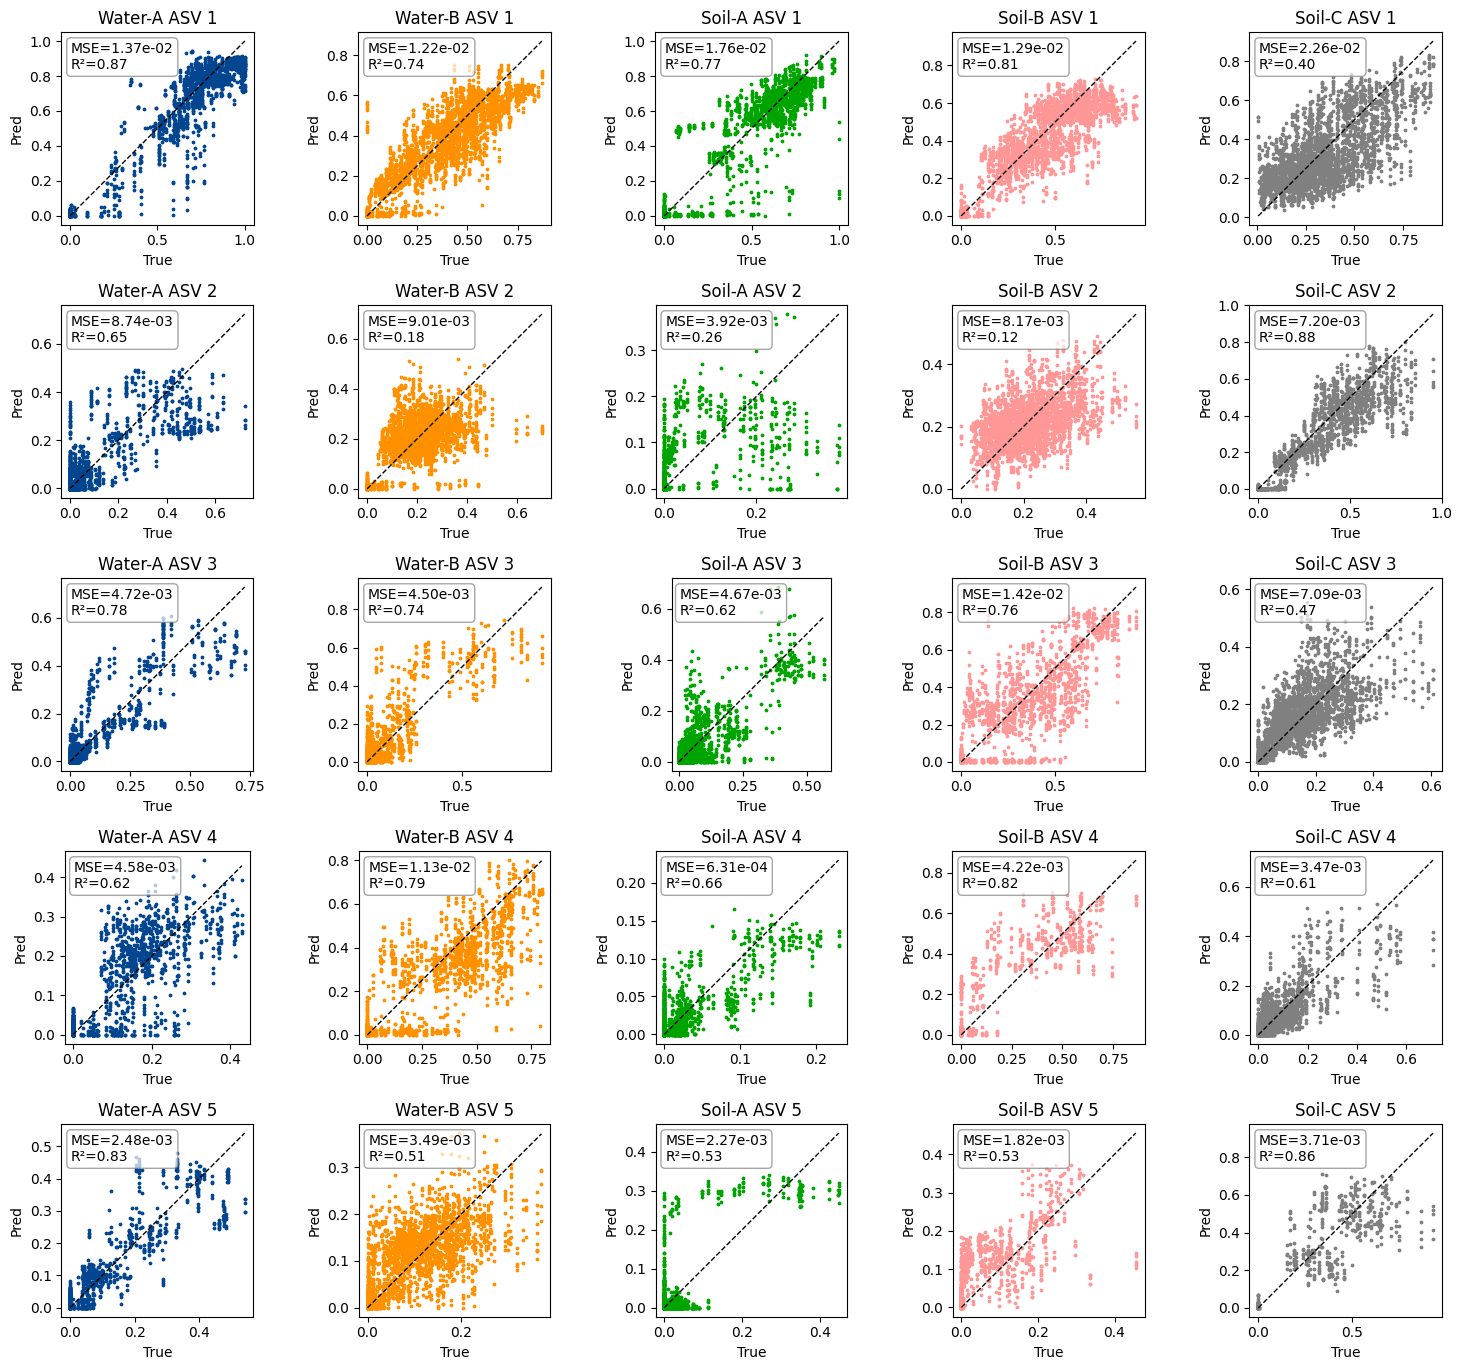

In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import torch
colors = ['#03468F', '#FF9000', '#00A400', '#FF9797', '#808080']
# Sample names
samples = ["Water-A", "Water-B", "Soil-A", "Soil-B", "Soil-C"]

# delta_T and other parameters
delta_T = 5
trial = 1
model_dir = "./mlp_models/target_forecast"
n_asv = 5

# Loop over each sample
fig, axes = plt.subplots(5, 5, figsize=(15,15))

# Loop through the samples
for sample_idx, sample in enumerate(samples):
    # Load data
    Seg1_all, Seg2_all = get_forecast_data_all(sample, delta_T, 5)
    n_reps, n_segs, _, T = Seg1_all.shape

    # Pick top-5 ASVs
    targets = np.arange(n_asv)

    # Containers for predictions and truths
    preds_dict = {asv: [] for asv in targets}
    truths_dict = {asv: [] for asv in targets}

    # Load Ec (embedding dimension)
    Ec = int(np.ceil(np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")[1, 0]))

    for test_rep in range(n_reps):
        # Load and move VAE+MLP to GPU
        vae = VAE(n_target=1, latent_dim=Ec).to("cuda:0")
        vae_ckpt = f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth"
        vae.load_state_dict(torch.load(vae_ckpt, weights_only=True))
        vae.eval()
        model = MLP_InLatent(vae).to("cuda:0").eval()
        ckpt = f"{model_dir}/{sample}_universal_fold{test_rep + 1}_{delta_T}day_trial{trial}.pth"
        model.load_state_dict(torch.load(ckpt, weights_only=True))

        # Output container: shape (n_segs, n_asv, T)
        preds = np.zeros((n_segs, n_asv, T))

        # Loop over ASVs and predict one-by-one
        for asv in range(n_asv):
            X_asv = Seg1_all[test_rep][:, asv, :]  # shape: (n_segs, T)
            X_asv = X_asv[:, None, :]              # add channel → (n_segs, 1, T)
            X_asv_t = torch.from_numpy(X_asv).float().to("cuda:0")

            with torch.no_grad():
                X_hat, _, _, _ = model(X_asv_t)  # shape: (n_segs, 1, T)

            preds[:, asv, :] = X_hat.squeeze(1).cpu().numpy()
        
        truth = Seg2_all[test_rep]

        # Collect only the last delta_T points
        for asv in targets:
            preds_flat = preds[:, asv, -delta_T:].reshape(-1)
            truth_flat = truth[:, asv, -delta_T:].reshape(-1)
            preds_dict[asv].extend(preds_flat.tolist())
            truths_dict[asv].extend(truth_flat.tolist())

    # ── Plotting ────────────────────────────────────────────────────────────────
    for idx, asv in enumerate(targets):
        ax = axes[idx,sample_idx]
        y_true = np.array(truths_dict[asv])
        y_pred = np.array(preds_dict[asv])
        mse = mean_squared_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        var = np.var(y_true)
        corr = np.corrcoef(y_true, y_pred)[0, 1]
        
        ax.scatter(y_true, y_pred, s = 3, color = colors[sample_idx])
        ax.plot([y_true.min(), y_true.max()],
                [y_true.min(), y_true.max()],
                'k--', linewidth=1)  # identity line
        ax.set_title(f"{sample} ASV {asv+1}")
        ax.set_xlabel("True")
        ax.set_ylabel("Pred")
        # annotate in upper-left corner
        ax.text(0.05, 0.95,
                f"MSE={mse:.2e}\nR²={r2:.2f}",
                transform=ax.transAxes,
                va='top',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))
        ax.set_aspect('equal')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## data collection: save R2 for across $\Delta T$ and 5 trials

In [8]:
# Sample names
samples = ["Water-A", "Water-B", "Soil-A", "Soil-B", "Soil-C"]

DT = [1, 2, 5, 10]

T = 30

model_dir = "./mlp_models/target_forecast"
n_asv = 5
# Pick top-5 ASVs
targets = np.arange(n_asv)

# Loop through the samples
for sample_idx, sample in enumerate(samples):
    R2_matrix = np.zeros((5,4,5)) # asv, deltaT, trial 
    # Load Ec (embedding dimension)
    Ec = int(np.ceil(np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")[1, 0]))
    # Load and move VAE+MLP to GPU
    vae = VAE(n_target=1, latent_dim=Ec).to("cuda:0")
    vae_ckpt = f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth"
    vae.load_state_dict(torch.load(vae_ckpt, weights_only=True))
    vae.eval()
    for i,delta_T in enumerate(DT):
        # Load data
        Seg1_all, Seg2_all = get_forecast_data_all(sample, delta_T, 5)
        n_reps, n_segs, _, _ = Seg1_all.shape
        for trial in range(5):
            # Containers for predictions and truths
            preds_dict = {asv: [] for asv in targets}
            truths_dict = {asv: [] for asv in targets}
            for test_rep in range(n_reps):
                model = MLP_InLatent(vae).to("cuda:0").eval()
                ckpt = f"{model_dir}/{sample}_universal_fold{test_rep + 1}_{delta_T}day_trial{trial+1}.pth"
                model.load_state_dict(torch.load(ckpt, weights_only=True))
                # Output container: shape (n_segs, n_asv, T)
                preds = np.zeros((n_segs, n_asv, T))
        
                # Loop over ASVs and predict one-by-one
                for asv in range(n_asv):
                    X_asv = Seg1_all[test_rep][:, asv, :]  # shape: (n_segs, T)
                    X_asv = X_asv[:, None, :]              # add channel → (n_segs, 1, T)
                    X_asv_t = torch.from_numpy(X_asv).float().to("cuda:0")
        
                    with torch.no_grad():
                        X_hat, _, _, _ = model(X_asv_t)  # shape: (n_segs, 1, T)
        
                    preds[:, asv, :] = X_hat.squeeze(1).cpu().numpy()
                
                truth = Seg2_all[test_rep]
        
                # Collect only the last delta_T points
                for asv in targets:
                    preds_flat = preds[:, asv, -delta_T:].reshape(-1)
                    truth_flat = truth[:, asv, -delta_T:].reshape(-1)
                    preds_dict[asv].extend(preds_flat.tolist())
                    truths_dict[asv].extend(truth_flat.tolist())
            for asv in targets:
                y_true = np.array(truths_dict[asv])
                y_pred = np.array(preds_dict[asv])
                r2 = r2_score(y_true,y_pred)
                R2_matrix[asv,i,trial]=r2 # asv, deltaT, trial 
    np.save(f"./target_forecast/R2/{sample}_R2.npy",R2_matrix)
    print(f"{sample} finished")


Water-A finished
Water-B finished
Soil-A finished
Soil-B finished
Soil-C finished


## save the predicted time series
* redefine the MLP model so it will return both the embedding of the input time series (day 1 - 30), and the embedding of the output (day 6 - day 35)

In [8]:
class MLP_InLatent(nn.Module):
    def __init__(self, vae):
        super().__init__()
        self.vae = vae

        self.channels = 512

        # 1) Freeze every VAE parameter
        for p in self.vae.parameters():
            p.requires_grad = False
        self.vae.eval()  # optional, puts dropout/bn in eval mode

        latent_dim = vae.latent_dim
        self.mlp = nn.Sequential(
            nn.Linear(latent_dim, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, self.channels),
            nn.LeakyReLU(),
            nn.Linear(self.channels, latent_dim),
        )

    def forward(self, X):
        """
        Args:
            X: (B, n_target, L)
        Returns:
            X_hat:   (B, n_target, L)  ← decoded from z_mapped
            z:       (B, latent_dim)   ← latent of the input
            z_mapped:(B, latent_dim)   ← z after MLP
            mu:      (B, latent_dim)   ← from VAE encoder
            log_var: (B, latent_dim)   ← from VAE encoder
        """
        # 1) run through frozen encoder & sampler
        with torch.no_grad():
            pre_code = self.vae.encoder(X)              # → (B, C, L)
            B, C, L = pre_code.shape
            flat   = pre_code.view(B, C * L)            # → (B, C*L)
            mu     = self.vae.mean_map(flat)            # → (B, latent_dim)
            log_var= self.vae.std_map(flat)             # → (B, latent_dim)
            z      = self.vae.sample(mu, log_var)       # → (B, latent_dim)

        # 2) map in latent space
        z_mapped = self.mlp(z)                          # → (B, latent_dim)

        # 3) decode via the original VAE’s decoder
        post = self.vae.fc_decoder(z_mapped)            # → (B, C*L)
        X_hat = self.vae.decoder(post.view(B, C, L))    # → (B, n_target, L)

        return X_hat, z, z_mapped, mu, log_var

In [12]:
import os
sample = "Soil-C"
delta_T = 5

Seg1_all, Seg2_all = get_forecast_data_all(sample, delta_T, 5)
n_reps, n_segs, n_asv, T = Seg1_all.shape

trial = 1
save_dir = f"./target_forecast/forecast_illustration"
os.makedirs(save_dir, exist_ok=True)

targets = np.arange(5)
Ec = int(np.ceil(np.loadtxt(f"./lab_microbiome_embedding_FUV_CV/{sample}_Ec.txt")[1,0]))
vae = VAE(n_target=1, latent_dim=Ec).to("cuda:0")
vae_ckpt = f"./vae_models_CV/{sample}_T1_E{Ec}_full.pth"
vae.load_state_dict(torch.load(vae_ckpt, weights_only=True))
vae.eval()
for asv in targets:
    # Input: (N, T)
    X_concat = []
    # Last 5 timepoints of ground truth: (N, 5)
    Y_tail_concat = []
    # Prediction: (N, T)
    Y_pred_concat = []
    # Embeddings
    Z_concat = []         # (N, Ec)
    Zmapped_concat = []   # (N, Ec)

    for test_rep in range(n_reps):
        # Grab X and Y for this replicate
        X_asv = Seg1_all[test_rep][:, asv, :]        # shape (n_segs, T)
        Y_true = Seg2_all[test_rep][:, asv, :]       # shape (n_segs, T)
        ckpt = f"./mlp_models/target_forecast/{sample}_universal_fold{test_rep + 1}_{delta_T}day_trial{trial}.pth"

        # Load model for this fold
        model = MLP_InLatent(vae).to("cuda:0").eval()
        model.load_state_dict(torch.load(ckpt, weights_only=True))

        X_asv_t = torch.from_numpy(X_asv[:, None, :]).float().to("cuda:0")
        with torch.no_grad():
            Y_pred_t, z_t, z_mapped_t, _, _ = model(X_asv_t)

        Y_pred = Y_pred_t.squeeze(1).cpu().numpy()       # (n_segs, T)
        z = z_t.cpu().numpy()                            # (n_segs, Ec)
        z_mapped = z_mapped_t.cpu().numpy()              # (n_segs, Ec)

        # Collect
        X_concat.append(X_asv)                           # (n_segs, T)
        Y_tail_concat.append(Y_true[:, -delta_T:])       # (n_segs, 5)
        Y_pred_concat.append(Y_pred)                     # (n_segs, T)
        Z_concat.append(z)                               # (n_segs, Ec)
        Zmapped_concat.append(z_mapped)                  # (n_segs, Ec)

    # Stack across all replicates
    X_full = np.vstack(X_concat)            # (N, T)
    Y_tail = np.vstack(Y_tail_concat)       # (N, 5)
    Y_pred = np.vstack(Y_pred_concat)       # (N, T)
    Z_all   = np.vstack(Z_concat)           # (N, Ec)
    Zmap_all = np.vstack(Zmapped_concat)    # (N, Ec)

    ground_truth = np.concatenate([X_full, Y_tail], axis=1)  # shape (N, T+5)

    # Save
    np.save(os.path.join(save_dir, f"ground_truth_{sample}_ASV{asv}.npy"), ground_truth)
    np.save(os.path.join(save_dir, f"prediction_{sample}_ASV{asv}.npy"), Y_pred)
    np.save(os.path.join(save_dir, f"z_{sample}_ASV{asv}.npy"), Z_all)
    np.save(os.path.join(save_dir, f"z_mapped_{sample}_ASV{asv}.npy"), Zmap_all)


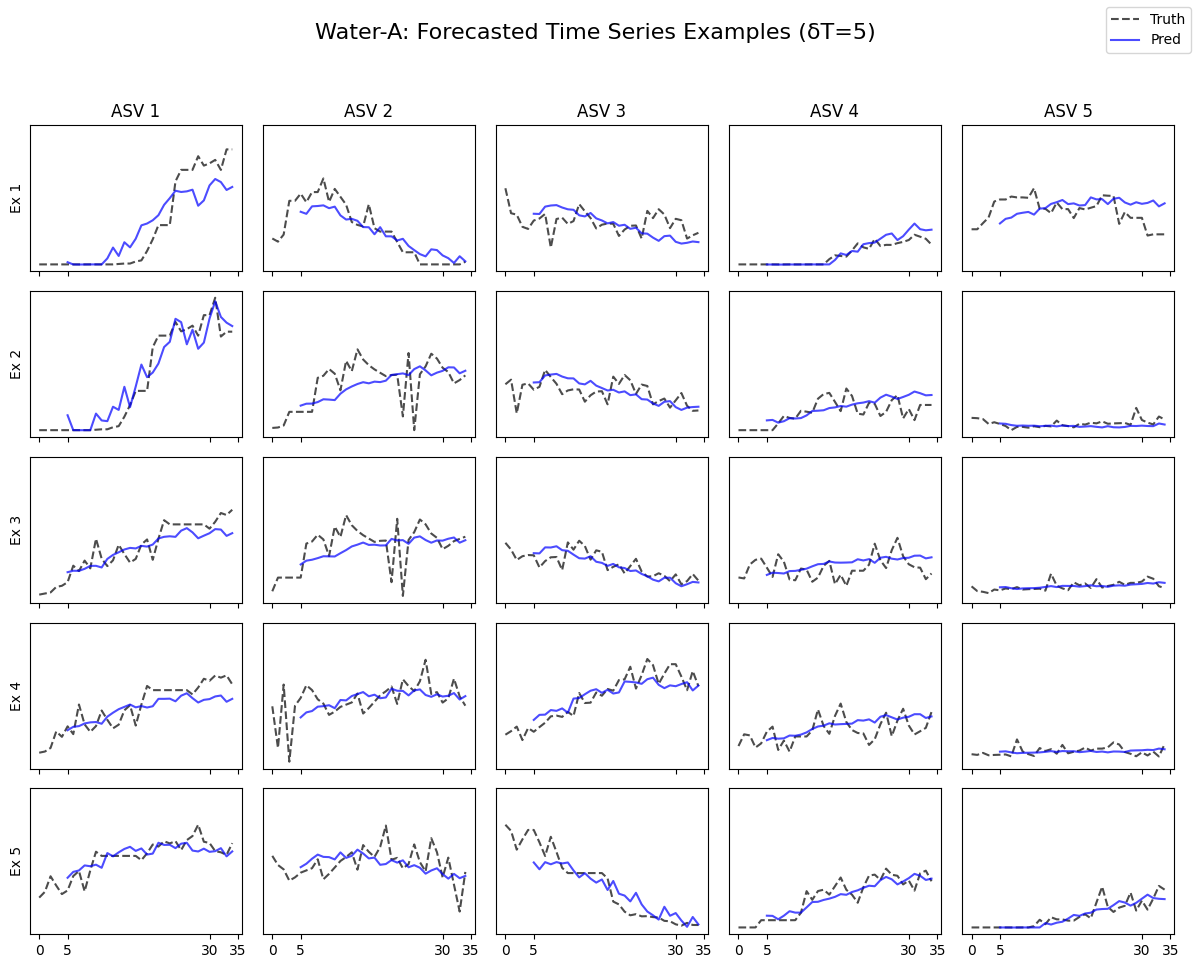

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os

sample = "Water-A"
delta_T = 5
trial = 1
targets = np.arange(5)
T = Seg1_all.shape[-1]  # original input time length

# Load saved arrays
save_dir = f"./target_forecast/forecast_illustration"
ground_truth_all = [np.load(f"{save_dir}/ground_truth_{sample}_ASV{asv}.npy") for asv in targets]  # list of (N, T+5)
prediction_all   = [np.load(f"{save_dir}/prediction_{sample}_ASV{asv}.npy")   for asv in targets]  # list of (N, T)

# Plot: 5 examples per ASV
fig, axes = plt.subplots(5, 5, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.reshape(5, 5)

for col, asv in enumerate(targets):
    gt = ground_truth_all[asv]    # shape (N, T+5)
    pred = prediction_all[asv]    # shape (N, T)
    var = np.var(gt[:, :-delta_T], axis=1)  # variability of input region

    # Choose 5 informative examples (top-50 by input variance, then 5 random picks)
    top_50_idx = np.argsort(var)[-100:][::-1]
    chosen_idx = sorted(random.sample(list(top_50_idx), 5))

    for row, idx in enumerate(chosen_idx):
        gt_ts = gt[idx]       # shape (T+5,)
        pred_ts = pred[idx]   # shape (T,)
        ax = axes[row, col]
        ax.plot(gt_ts, 'k--', alpha=0.7, label="Truth" if row == 0 and col == 0 else "")
        ax.plot(np.arange(delta_T,T+delta_T), pred_ts, 'b', alpha=0.7, label="Pred" if row == 0 and col == 0 else "")
        if col == 0:
            ax.set_ylabel(f"Ex {row+1}")
        if row == 0:
            ax.set_title(f"ASV {asv+1}")
        ax.set_xticks([0,5,30,35])
        ax.set_yticks([])

# Add legend
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle(f"{sample}: Forecasted Time Series Examples (δT={delta_T})", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
